## Libraries to be imported

In [1]:
from bs4 import BeautifulSoup as bs
from urllib.request import urlopen
import re
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
pd.set_option("display.max_row",999)

## Data Collection

### List of Players for a country (To look up for the country name)

In [9]:
country_player=pd.read_csv("/home/atanu/Desktop/Code/Country_player.csv",header=None)
country=country_player[0]
player_list=pd.DataFrame()
country_player1=pd.DataFrame(columns=['Country','Name'])
for num,con in enumerate(country):
    play=[]
    for i in country_player:
        if i != 0:
            play.append(country_player[i][num])
    country_player1['Name']=play
    country_player1['Country']=country[num]
    player_list=player_list.append(country_player1,ignore_index=True)

### Scrapping the Cricbuzz to get the scores of the player

In [4]:
html_sch="https://www.cricbuzz.com/cricket-series/2697/icc-cricket-world-cup-2019/matches"
url_sch=urlopen(html_sch)
soup_sch=bs(url_sch,'lxml')
sch_a=soup_sch.findAll('a',attrs={'href': re.compile("^/cricket-scores/")})
links=[]
for i in sch_a:
    links.append(i.get('href'))

In [5]:
links.append('/cricket-scores/20276/ban-vs-ind-match-40-icc-cricket-world-cup-2019')
links.append('/cricket-scores/20277/eng-vs-nz-match-41-icc-cricket-world-cup-2019')
links.append('/cricket-scores/20279/pak-vs-ban-match-43-icc-cricket-world-cup-2019')
links.append('/cricket-scores/20280/sl-vs-ind-match-44-icc-cricket-world-cup-2019')
links.append('/cricket-scores/20281/aus-vs-rsa-match-45-icc-cricket-world-cup-2019')


In [6]:
b=[]
for a in links:
    if a not in b:
        b.append(a)

In [7]:
link_final=[]
for i in b:
    link_final.append('https://www.cricbuzz.com/live-cricket-scorecard' + i[15:])

### Preparing the Dataframe Containg the Bowler records and the Average

In [35]:
bowler=pd.DataFrame(columns=['Match','Name','Over','Maiden','Run','Wicket','Wide','NB','eco'])

In [36]:
for link in link_final:
    bowler_temp=pd.DataFrame(columns=['Match','Name','Over','Maiden','Run','Wicket','Wide','NB','eco'])
    try:
        url=link
        html=urlopen(url)
        soup=bs(html,'lxml')
        all_div=soup.find_all('div' ,{"cb-col cb-col-100 cb-scrd-itms "})
        tit=soup.title
        m=re.search(r'Match (\d+)',tit.text)
        #print(f'Loading {m}')
    except Exception :  
        print(f'Error happened while connecting {link}')
    ball_name=[]
    ball_over=[]
    ball_maiden=[]
    ball_run=[]
    ball_wicket=[]
    ball_wide=[]
    ball_nb=[]
    ball_eco=[]
    for i in all_div:
        ball_name.append(i.contents[1].text)
        ball_over.append(i.contents[3].text)
        ball_maiden.append(i.contents[5].text)
        ball_run.append(i.contents[7].text)
        ball_wicket.append(i.contents[9].text)
        ball_nb.append(i.contents[11].text)
        ball_wide.append(i.contents[13].text)
        ball_eco.append(i.contents[15].text)
        
    bowler_temp['Name']=ball_name
    bowler_temp['Over']=ball_over
    bowler_temp['Wide']=ball_wide
    bowler_temp['Maiden']=ball_maiden
    bowler_temp['Run']=ball_run
    bowler_temp['Wicket']=ball_wicket
    bowler_temp['NB']=ball_nb
    bowler_temp['eco']=ball_eco
    bowler_temp['Match']=m.group(1)    
    bowler_temp['Country']=''
    for name in list(bowler_temp['Name']):
        if name.strip() in [b.strip() for b in player_list['Name']]:
            bowler_temp.loc[bowler_temp['Name'].str.strip()==name.strip(),['Country']]=list(player_list[player_list['Name'].str.strip()==name.strip()]['Country'])[0]
        else:
            bowler_temp.loc[bowler_temp['Name'].str.strip()==name.strip(),['Country']]='Nan'
    bowler_temp['Run']=pd.to_numeric(bowler_temp['Run'])
    bowler_temp['Over']=pd.to_numeric(bowler_temp['Over']) 
    tab_run=pd.DataFrame(data=bowler_temp.groupby(['Country'])['Run'].sum())
    tab_ball=pd.DataFrame(data=bowler_temp.groupby(['Country'])['Over'].sum())
    tab_run.reset_index(inplace=True)
    tab_ball.reset_index(inplace=True)
    #bowler.groupby(['Country'])['Run'].sum()
    tab_run=tab_run.rename(columns={'Run':'Total_run'})
    tab_ball=tab_ball.rename(columns={'Over':'Total_Over'})
    tab_run=tab_run.merge(tab_ball,on='Country')
    bowler_temp=bowler_temp.merge(tab_run,on='Country')
    #pd.to_numeric(bowler_temp['Total_Over'])
    bowler_temp['average']=(100.0+(1.0 +(pd.to_numeric(bowler_temp['Total_run'])/50.0)-pd.to_numeric(bowler_temp['eco']))*10-(10.0-pd.to_numeric(bowler_temp['Over']))+(pd.to_numeric(bowler_temp['Wicket'])*3))/2
    #print(bowler_temp)
    bowler=bowler.append(bowler_temp,ignore_index=True,sort=True)

## Analyzing the data

In [133]:
#Change the country name to see the analysis of the team
name=[a.strip()  for a in bowler[bowler['Country'].str.strip()=='India']['Name'] ]
#name=['Mitchell Starc','Jasprit Bumrah','Jofra Archer','Mohammad Amir']

In [134]:
india_player=[]
for a in name:
    if a not in india_player:
        india_player.append(a)

In [135]:
indian_bowler=bowler[bowler['Name'].str.strip().isin(name)]

In [136]:
indian_bowler['Match']=indian_bowler['Match'].astype(int)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [137]:
indian_bowler['Name']=indian_bowler['Name'].str.strip()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [138]:
indian_bowler=indian_bowler.pivot(index='Match', columns='Name', values='average').sort_index()

In [139]:
bar=[]
for num,a in enumerate(india_player):
    if num<=8:
        bar.append(indian_bowler[a].values)

In [140]:
r=[]
barwidth=.15
for num,arr in enumerate(bar):
    if num==0 :
        r.append(np.arange(len(bar[num])))
    else:
        r.append([x + barwidth for x in r[num-1]])

In [141]:
color=['red','green','blue','black','yellow','orange','violet','pink','brown']

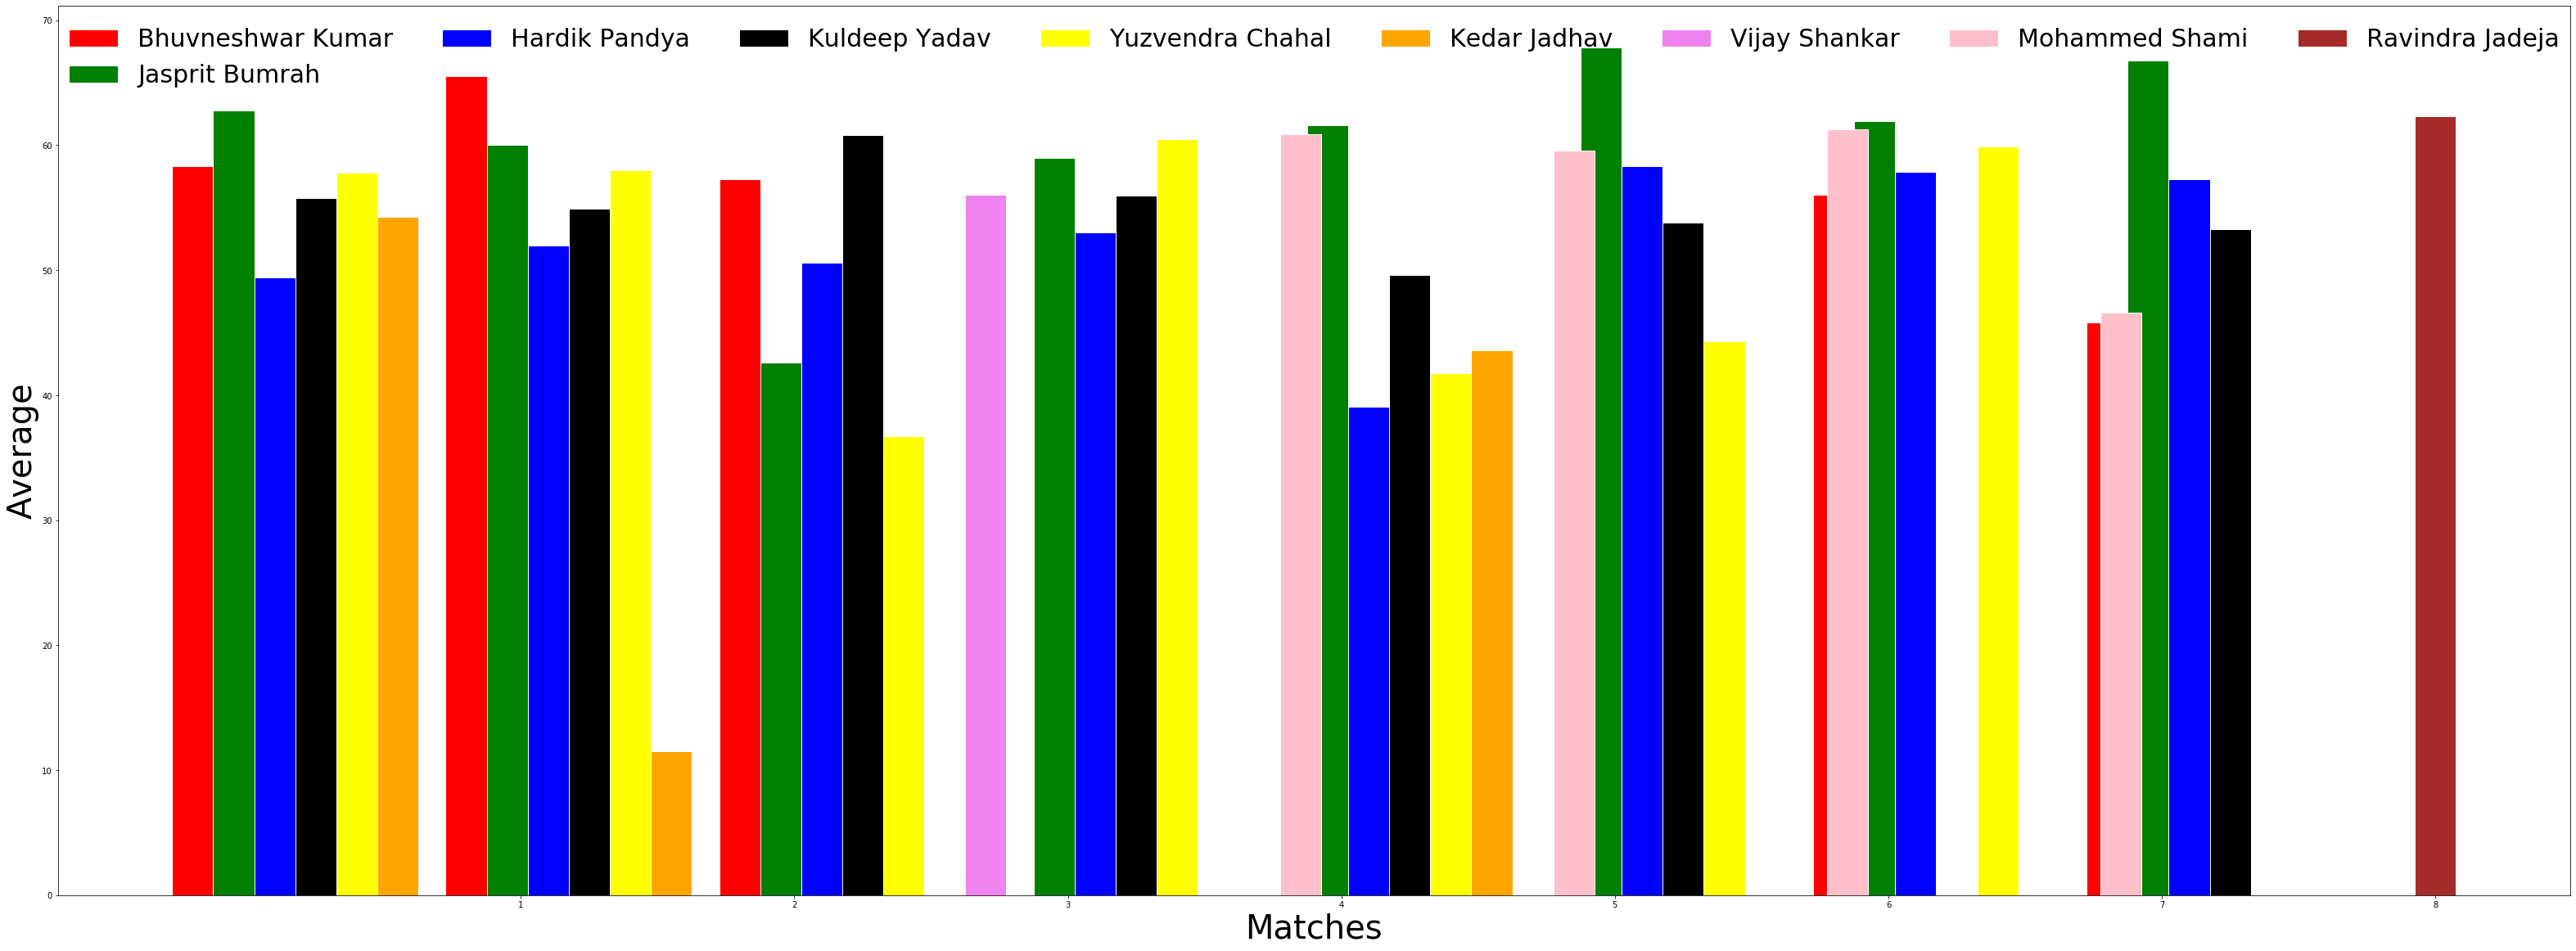

In [142]:
plt.figure(figsize=(55,20))
for num,arr in enumerate(bar):
    
    plt.bar(r[num], bar[num], color=color[num], width=barwidth, edgecolor='white', label=india_player[num])
    plt.xticks(r[num], ['1', '2', '3', '4', '5','6','7','8'])
    #plt.yticks(indian_bowler['Average'])
    plt.legend(frameon=False, loc='upper center', ncol=num,fontsize=30)
    plt.xlabel('Matches',fontsize=40)
    plt.ylabel('Average',fontsize=40)
    
